In [287]:
import zipfile
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

## Additional functions

In [87]:
class InvensensePressureConversion: 
    """ Class for conversion of the pressure and temperature output 
    of the Invensense 
    sensor""" 
    def __init__(self, sensor_constants):
        """ Initialize customer formula
        Arguments:
        sensor_constants --   list of 4 integers: [c1, c2, c3, c4] 
        """
        self.sensor_constants = sensor_constants
        # configuration for ICP-101xx Samples
        self.p_Pa_calib = [45000.0, 80000.0, 105000.0]
        self.LUT_lower = 3.5 * (2**20)
        self.LUT_upper = 11.5 * (2**20)
        self.quadr_factor = 1 / 16777216.0
        self.offst_factor = 2048.0 
    def calculate_conversion_constants(self, p_Pa, p_LUT):
        """ calculate temperature dependent constants
        Arguments:
        p_Pa 
        --   List of 3 values corresponding to applied pressure in Pa
        p_LUT 
        --   List of 3 values corresponding to the measured p_LUT values at the applied pressures.
        """
        C = (p_LUT[0] * p_LUT[1] * (p_Pa[0] -  p_Pa[1]) + p_LUT[1] * p_LUT[2] * (p_Pa[1] - p_Pa[2]) +   p_LUT[2] * p_LUT[0] * (p_Pa[2] - p_Pa[0])) / \
            (p_LUT[2] * (p_Pa[0] - p_Pa[1]) +p_LUT[0] * (p_Pa[1] - p_Pa[2]) +  p_LUT[1] * (p_Pa[2] - p_Pa[0]))
        A = (p_Pa[0] * p_LUT[0] -p_Pa[1] * p_LUT[1] -(p_Pa[1] - p_Pa[0]) * C) / (p_LUT[0] -p_LUT[1])
        B = (p_Pa[0] - A)   * (p_LUT[0] + C)
        return [A, B, C]

    def get_pressure(self, p_LSB, T_LSB):
        t = T_LSB - 32768.0
        s1 = self.LUT_lower + float(self.sensor_constants[0] * t * t) * self.quadr_factor
        s2 = self.offst_factor * self.sensor_constants[3] + float(self.sensor_constants[1] * t * t) * self.quadr_factor
        s3 = self.LUT_upper + float(self.sensor_constants[2] * t * t) * self.quadr_factor
        A, B, C = self.calculate_conversion_constants(self.p_Pa_calib, [s1, s2, s3])
        return A + B / (C + p_LSB) 
    
def unsign(val):
    if val<0:
        return pow(2,24) + val;
    else:
        return val;
    
def unsign_list(vals):
    return array(list(map(unsign,vals)))

## Sensor specific functions

In [201]:
# TODO: change ref mensor column name

def SensorDataCheck(DataTable):
    pass

def Convert(ADCT, ADCP, Coeffs):
    converter = InvensensePressureConversion([Coeffs['c1'],Coeffs['c2'],Coeffs['c3'], Coeffs['c4']])
    Tsens = -45+175.0/pow(2,16)*ADCT;
    Psens = np.array([ converter.get_pressure(unsign(pair[0]),pair[1]) for pair in np.column_stack([ADCP, ADCT])])
    
    return (Tsens, Psens)

def CheckCoeffs(CoeffRaw):
    pass

# preprocess coeffitiens 
# return a dictionary, that will be passed as Coeffs variable into Convert function
def CalcCoeffs(CoeffRaw):
    Coeffs = dict()
    Coeffs['c1'] = CoeffRaw['OTP_REG1_(LSB)'][0]
    Coeffs['c2'] = CoeffRaw['OTP_REG2_(LSB)'][0]
    Coeffs['c3'] = CoeffRaw['OTP_REG3_(LSB)'][0]
    Coeffs['c4'] = CoeffRaw['OTP_REG4_(LSB)'][0]
    return Coeffs



## ---------------------------------------------------------

## Coeff preprocessing - general

In [200]:
# global setups
CoeffFilePattern = 'otp'
ModeFilePatterns = ['val']
ModeNames = ['Normal']
ADCP_colname = 'ADCP_(LSB)'
ADCT_colname = 'ADCT_(LSB)'
Timestamp_colname = 'TIMESTAMP_(usec)'

In [202]:
def ProcessCoeffs(ResultFile):
    CoeffRaw = dict()
    # Read up coeff files
    with zipfile.ZipFile(ResultFile,'r') as zf:
        for fname in zf.namelist():
            if fname.endswith('.mds') and fname.find(CoeffFilePattern) > -1:

                Sidx = int(re.findall('_SIdx([0-9]+)',fname)[0])
                if Sidx == 99:
                    # skip pressure reference file
                    continue

                with zf.open(fname,'r') as f:
                    Content = pd.read_csv(f,sep=';' , skiprows = 25, encoding='ansi', skipinitialspace=True)                
                    SensorCoeff = CoeffRaw.get(Sidx,None)
                    if SensorCoeff is None:
                        SensorCoeff = Content
                    else:
                        SensorCoeff = pd.concat([SensorCoeff, Content],ignore_index=True)

                    CoeffRaw[Sidx] = SensorCoeff

    # Process coeff files
    Coeffs = dict()
    for SIdx in CoeffRaw.keys():
        if CheckCoeffs(CoeffRaw[SIdx]) is False:
            print('Coeff file check failed.\nFile content:')
            print(CoeffRaw[SIdx])
        else:
            Coeffs[SIdx] = CalcCoeffs(CoeffRaw[SIdx])
            
    return Coeffs

## Sensor data processing - general

In [284]:
def ForEachSensorFile(ResultFile, SensorCallback, **kwargs):
    SIdxFilter = kwargs.get('SIdxFilter',None)
    
    with zipfile.ZipFile(ResultFile,'r') as zf:
        for fname in zf.namelist():
            if fname.endswith('.mds'):
                Sidx = int(re.findall('_SIdx([0-9]+)',fname)[0])
                if Sidx == 99:
                    continue
                if (SIdxFilter is not None) and (Sidx not in list(SIdxFilter)):
                    continue

                modeFound = ''
                for (ModePattern, ModeName) in zip(ModeFilePatterns, ModeNames):
                    if fname.find(ModePattern) > -1 and len(ModePattern) > len(modeFound):
                        modeFound = ModeName

                if len(modeFound) == 0:
                          continue

                with zf.open(fname,'r') as f:
                    Content = pd.read_csv(f,sep=';' , skiprows = 25, encoding='ansi', skipinitialspace=True)

                    kwargs['SIdx'] = Sidx
                    kwargs['FileName'] = fname
                    kwargs['Mode'] = modeFound
                    SensorCallback(Content, **kwargs)

class SummaryCreator(object):
    def __init__(self):
        self.Summary = Summary = pd.DataFrame(columns=['SIdx', 'Mode', 'Tset', 'Pset', 'Tref_avg','Tref_min','Tref_max','Tref_std', 'Pdiff_avg',  'Pdiff_min','P_diff_max','P_diff_std','Tsens_avg', 'Tsens_min','Tsens_max','Tsens_std'])
        
    def ProcessFile(self, Content, **kwargs):
        FileName = kwargs.get('FileName','')
        Mode = kwargs.get('Mode','unknown')
        SIdx = kwargs.get('SIdx',None)
        
        print('Processing file: %s' % FileName)
        
        SensorDataCheck(Content)

        # do the conversion
        (Tsens, Psens) = Convert(Content[ADCT_colname].values,Content[ADCP_colname].values, Coeffs[Sidx])

        # determine wether the pressure controller was off during the measurement            
        if Content['LOOPINDEX'][0] == 1:
            was_press_controller_off = True
        else:
            was_press_controller_off = False

        if was_press_controller_off == True:                
            # calculate global timestamps
            Ts_global = Content['TIME_START_(s)'] + Content[Timestamp_colname]*1e-6

            # calculate interpolated reference pressure
            P_ref
        else:
            P_ref = Content['P_CONTROLLER_(Pa)']

        Pdiff = Psens - P_ref


        Tref = Content['T_PT100_(°C)']
        Tdiff =  Tsens - Tref

        # construct output table
        newRow = {
            'SIdx' : SIdx,
            'Mode' : Mode,
            'Tset' : Content['T_SET_(°C)'][0],
            'Tref_avg': np.mean(Tref),
            'Tref_min': np.min(Tref),
            'Tref_max' : np.max(Tref),
            'Tref_std' : np.std(Tref),
            'Pset' : Content['P_SET_(Pa)'][0],
            'Pdiff_avg': np.mean(Pdiff),
            'Tsens_avg' : np.mean(Tsens),
            'Pdiff_min' : np.min(Pdiff),
            'P_diff_max' : np.max(Pdiff),
            'P_diff_std' : np.std(Pdiff),
            'Tsens_min' : np.min(Tsens),
            'Tsens_max' : np.max(Tsens),
            'Tsens_std' : np.std(Tsens)                
        }
        self.Summary = self.Summary.append(newRow, ignore_index = True)    
        
    def GetSummary(self):
        return self.Summary
        
def CreateSummary(Coeffs, ResultFile):

    # read up reference pressure file:
    P_ref_content = None
    with zipfile.ZipFile(ResultFile,'r') as zf:
        fileNames = zf.namelist()
        for fn in fileNames:
            if fn.find('SIdx099') > -1:
                P_ref_content = pd.read_csv(f,sep=';' , skiprows = 25, encoding='ansi', skipinitialspace=True)  

    c = SummaryCreator()    
    ForEachSensorFile(ResultFile, c.ProcessFile, P_ref_content = P_ref_content)
    print('Data processing ready.')            
    return c.GetSummary()



def PlotData(ResultFile, **kwargs):
    f, axarr = plt.subplots(2, sharex=True)
    Pcanvas = axarr[0]
    Tcanvas = axarr[1]
    
    def SensorEval(Content, **kwargs):
        
        Mode = kwargs.get('Mode')        
        Pset = Content['P_SET_(Pa)'][0]
        Tset = Content['T_SET_(°C)'][0]
        Tref = np.mean(Content['T_PT100_(°C)'])
        SIdx = kwargs.get('SIdx')
        
        (Tsens, Psens) = Convert(Content[ADCT_colname].values,Content[ADCP_colname].values, Coeffs[Sidx])
        
        if 'Pset' in kwargs and kwargs['Pset']is not None and kwargs['Pset'] != Pset:
            return
            
        if 'Tset' in kwargs and kwargs['Tset']  is not None and kwargs['Tset'] != Tset:
            return
            
        if 'Mode' in kwargs and kwargs['Mode'] is not None and kwargs['Mode'] != Mode:
            return
            
        # if all filters are passed, then plot
        
        Tcanvas = kwargs.get('Tcanvas')
        Ts = Content[Timestamp_colname]
        Tcanvas.plot(Ts, Tsens, label=('I: %d;  T: %s' % (SIdx,Tref)))
        
        Pcanvas = kwargs.get('Pcanvas')
        Pcanvas.plot(Ts,Psens/100, label=('I: %d,  P: %s' % (SIdx, Pset)))

    ForEachSensorFile(ResultFile, SensorEval, Tcanvas = Tcanvas, Pcanvas = Pcanvas, **kwargs)
    
    Pcanvas.legend()
    Tcanvas.legend()
            

## Single sensor view

In [217]:
ResultFile = 'H:/Letöltések/FMA_test.zip'

<IPython.core.display.Javascript object>


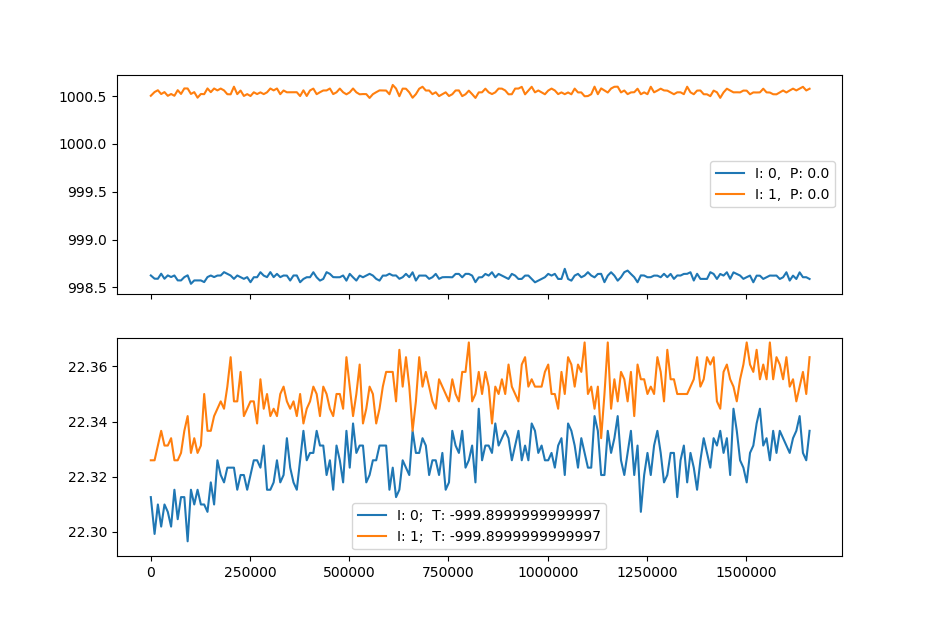

In [288]:
Coeffs = ProcessCoeffs(ResultFile)
SIdx = 0

PlotData(ResultFile, Pset = None)




## Sensor summary

In [289]:
Coeffs = ProcessCoeffs(ResultFile)
Summary = CreateSummary(Coeffs, ResultFile)
Summary

Processing file: FMA_ICP20190112_crc_2xSens/FMA_ICP20190112_M1424_J0nn_SIdx000_20190112_vals.mds
Processing file: FMA_ICP20190112_crc_2xSens/FMA_ICP20190112_M1424_J0nn_SIdx001_20190112_vals.mds
Data processing ready.


,SIdx,Mode,Tset,Pset,Tref_avg,Tref_min,Tref_max,Tref_std,Pdiff_avg,Pdiff_min,P_diff_max,P_diff_std,Tsens_avg,Tsens_min,Tsens_max,Tsens_std
0,0,Normal,0.0,0.0,-999.9,-999.9,-999.9,2.273737e-13,-137.140547,-144.720014,-129.060888,2.777142,22.32584,22.296600,22.344666,0.009039
1,1,Normal,0.0,0.0,-999.9,-999.9,-999.9,2.273737e-13,55.943380,49.641322,63.230481,2.775027,22.35078,22.325974,22.368698,0.009132
